## Analytically

In [1]:
import numpy as np
from scipy.optimize import minimize
import sympy as sp
from sympy.physics.quantum import TensorProduct, Dagger

In [8]:
def to_polar(M):
    return M.applyfunc(lambda z: round(sp.Abs(z),3) * sp.exp(sp.I * round(sp.arg(z).evalf(),3)))

In [9]:
Z = sp.Matrix([[1,0],[0,-1]])
X = sp.Matrix([[0,1],[1,0]])
I = sp.Matrix.eye(2)

plus = 1/sp.sqrt(2) * sp.Matrix([1,1])

In [10]:
H_c = sp.Matrix.eye(8) - sp.Rational(1,2) * (TensorProduct(Z,Z,I) + TensorProduct(Z,I,Z))
H_m = TensorProduct(X,I,I) + TensorProduct(I,X,I) + TensorProduct(I,I,X)

num_layers = 5

gammas = [0.5] * num_layers
betas = [0.5] * num_layers

In [47]:
def circuit(gammas, betas):
    phi = TensorProduct(plus, plus, plus)

    for i in range(num_layers):
        gamma = gammas[i]
        beta = betas[i]

        phi_c = (sp.exp(-sp.I * gamma * H_c) * phi).evalf()
        phi = (sp.exp(-sp.I * beta * H_m) * phi_c).evalf()

    expval = (Dagger(phi) * H_c * phi).evalf()[0]

    return phi, expval

def cost_fn(params):
    params = np.array(params)
    _, expval = circuit(params[:num_layers], params[num_layers:])
    return -expval

In [48]:
iters = 10

for i in range(iters):
    res = minimize(cost_fn, gammas + betas, method='Nelder-Mead',
               options={'disp': True, 'maxiter': 20, 'fatol': 0.1})

    gammas = res.x[:num_layers].tolist()
    betas = res.x[num_layers:].tolist()

    print(f'{i}) cost: {res.fun}')

/tmp/ipykernel_6228/1823413083.py:4: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(cost_fn, gammas + betas, method='Nelder-Mead',


0) cost: -1.4756907060903022
1) cost: -1.685490623888196
2) cost: -1.826937248662998
3) cost: -1.924365337551389
4) cost: -1.978070868034275
5) cost: -1.9991813073303537
6) cost: -1.9998904132916855
7) cost: -1.9999276508362203
8) cost: -1.9999760927959955
9) cost: -1.9999760927959955


In [49]:
phi, expval = circuit(gammas, betas)

In [52]:
to_polar(phi)

Matrix([
[0.002*exp(0.118*I)],
[0.002*exp(0.066*I)],
[0.002*exp(0.066*I)],
[0.707*exp(1.421*I)],
[0.707*exp(1.421*I)],
[0.002*exp(0.066*I)],
[0.002*exp(0.066*I)],
[0.002*exp(0.118*I)]])

Solutions: $\ket{011}$ and $\ket{100}$

## Pennylane

In [2]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

In [3]:
graph = nx.Graph([(0,1),(0,2)])
H_c, H_m = qaoa.maxcut(graph)

In [11]:
wires = [0, 1, 2]
num_layers = 5
dev = qml.device('default.qubit', wires=wires)

In [12]:
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_c)
    qaoa.mixer_layer(beta, H_m)

def circuit(gammas, betas):
    for w in wires:
        qml.Hadamard(w)

    qml.layer(qaoa_layer, num_layers, gammas, betas)

@qml.qnode(dev)
def cost_function(params):
    circuit(gammas=params[0], betas=params[1])
    return qml.expval(H_c)

In [10]:
#Optimization

opt = qml.GradientDescentOptimizer()
steps = 150
params = np.array([[0.5]*num_layers, [0.5]*num_layers], requires_grad=True)

for _ in range(steps):
    params = opt.step(cost_function, params)

In [11]:
@qml.qnode(dev)
def circuit_state(params):
    circuit(gammas=params[0], betas=params[1])
    return qml.state()

res = np.round(circuit_state(params), decimals=5)

In [12]:
psi = to_polar(sp.Matrix(res.tolist()))

In [13]:
psi

Matrix([
[0.08*exp(-1.972*I)],
[0.295*exp(2.452*I)],
[0.295*exp(2.452*I)],
[0.565*exp(2.837*I)],
[0.565*exp(2.837*I)],
[0.295*exp(2.452*I)],
[0.295*exp(2.452*I)],
[0.08*exp(-1.972*I)]])

In [14]:
import matplotlib.pyplot as plt
from itertools import product

def plot_quantum_state_probabilities(psi):
    # Convert SymPy matrix to a NumPy array (assuming numeric evaluation)
    psi_np = np.array(psi).astype(np.complex128).flatten()

    # Compute probabilities
    probabilities = np.abs(psi_np) ** 2

    # Determine the number of qubits (log2 of vector size)
    num_qubits = int(np.log2(len(psi_np)))
    
    # Generate binary labels for basis states
    basis_states = ["|" + "".join(map(str, bits)) + ">" 
                    for bits in product([0, 1], repeat=num_qubits)]
    
    # Plot the probabilities
    plt.figure(figsize=(8, 5))
    plt.bar(basis_states, probabilities, color='royalblue', alpha=0.7)
    plt.xlabel("Basis States")
    plt.ylabel("Probability")
    plt.title("Quantum State Probabilities")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

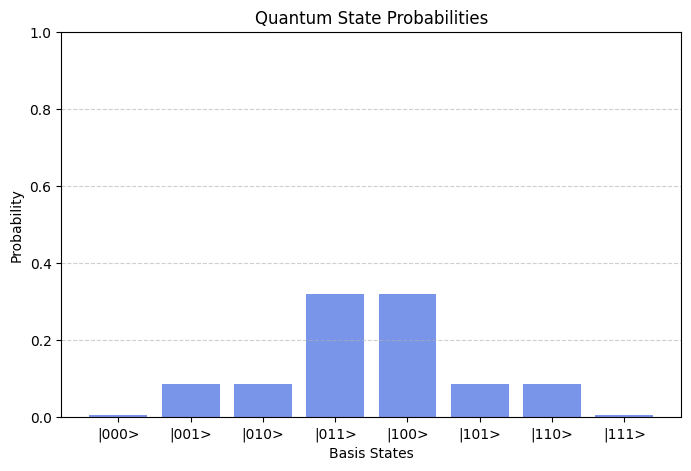

In [15]:
plot_quantum_state_probabilities(psi)